# Didactalia & AFEL activities

In this anaysis, we study the relations that may exist between the use of Didactalia and the use of the AFEL App.

# Import & Constants

## Fuseki Endpoint : you might want to change it!

In [1]:
FUSEKI_DATASET = "evalafel" # Change according your own dataset name
SPARQL_ENDPOINT = "http://localhost:3030/%s/query" % FUSEKI_DATASET

## Imports, constants settings

In [2]:
from SPARQLWrapper import SPARQLWrapper, CSV
from rdflib import Literal
import numpy as np
import pandas as pd
from io import BytesIO
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

In [3]:
SPARQL_PREFIX = """
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX afl: <http://vocab.afel-project.eu/>
    PREFIX extafl: <http://vocab.afel-project.eu/extension/>
    PREFIX sch: <http://schema.org/>
"""

In [4]:
# Setting seaborn to have proper visualisation adapted to jupyter notebook
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [5]:
def sparql_to_dataframe(query, **kwargs):
    sparql = SPARQLWrapper(SPARQL_ENDPOINT)
    sparql.setQuery(query)
    sparql.setReturnFormat(CSV)
    res = sparql.query().convert()
    try:
        with BytesIO(res) as sio:
            return pd.read_csv(sio, **kwargs)
    finally:
        del res
        gc.collect()

# Activities Extraction

In [6]:
def retrieve_users_activities():
    """
    Retrieve following activities:
        - didactlia: Artifact view, game played, search
        - AFEL App: Artifact view, RecommendedArtifact view
    """
    query = SPARQL_PREFIX + """
    SELECT ?userid ?location ?activityType ?actStartTime ?actEndTime
    WHERE {
        ?activity a ?activityType .
        ?activity afl:user ?user .
        ?activity afl:eventStartDate ?actStartTime .
        ?activity afl:eventEndDate ?actEndTime .
        ?activity sch:location ?location .
        ?user afl:userName ?userid .
        FILTER(?activityType IN (afl:ArtifactView, extafl:DidactaliaGamePlayed, afl:Search, extafl:RecommendedArtifactView, extafl:ScopeView))
    }
    """
    return sparql_to_dataframe(query, parse_dates=[3, 4])

In [7]:
def extract_users_activities(df, copy = False):
    if copy:
        df = df.copy()
    # Simplify users' ids
    df['userid'] = np.vectorize(int)(df.userid.str.extract('project.afel\+(\d+)', expand=False))
    # Simplify activityType
    df.activityType = df.activityType.str.split('/').str.get(-1)
    # Simplify location name
    df.loc[df.location == "https://didactalia.net", 'location'] = "didactalia"
    df.loc[df.location != "didactalia", 'location'] = "afel"
    # Sort by userid and actStartTime
    df.sort_values(['userid', 'actStartTime'], inplace=True)
    return df

# Activity duration computation

In [8]:
def compute_duration(df, drop_na = False, copy = False):
    if copy:
        df = df.copy()
    # Add shifted copy of userid and actStartTime
    for col in ['userid', 'actStartTime']:
        df[col + '_next'] = df[col].shift(-1)
    # Add an false int indicator to the userid_next last line and reconvert the column to int 
    df.iloc[df.shape[0] - 1, np.where(df.columns == 'userid_next')[0][0]] = -1
    df.userid_next = df.userid_next.astype(int)
    # Compute duration of activities
    df['actTime'] = np.NaN
    # If we have the same userId & catQuest for the activity and the next, then we compute the difference 
    df.loc[df.userid == df.userid_next, 'actTime'] = (df.actStartTime_next - df.actStartTime) / np.timedelta64(1, 's')
    # If startTime is strictly before endTime, use them to compute length (careful : conversion is done in nanosec)
    df.loc[df.actStartTime < df.actEndTime,'actTime'] = (df.actEndTime - df.actStartTime) / np.timedelta64(1, 's')
    # delete temporary columns
    del df['userid_next'], df['actStartTime_next']
    # we drop trace whose length was not able to be computed
    if drop_na:
        old_len = df.shape[0]
        df.dropna(inplace=True)
        if old_len > df.shape[0]:
            print("Dropped %d samples that do not have any length" % (old_len - df.shape[0]))
    else:
        df.fillna(0, inplace=True)
    return df

In [9]:
DF_ACT = compute_duration(extract_users_activities(retrieve_users_activities()))

# Compute independent and dependent variables

We compute all features by user: 
- number of didactalia activities
- total duration of didactalia activities
- mean / stddev duration of didactalia activities
- number of afel activities
- toal duration of afel activities
- mean / stddev duration of afel activities

In [10]:
def split_by_location(df):
    others_columns = list(filter(lambda x: x != 'location', df.columns))
    df_didactalia = df.loc[df.location == 'didactalia', others_columns]
    df_afel = df.loc[df.location == 'afel', others_columns]
    return df_didactalia, df_afel

In [11]:
def compute_num_act_features(df, suffix):
    suffix = '_' + suffix
    return df.loc[:,['userid', 'activityType']].groupby('userid').count()\
    .rename(columns={'activityType':'nbAct' + suffix})

In [12]:
def compute_duration_features(df, suffix):
    suffix = '_' + suffix
    # total and mean duration of didactalia activities
    df2 = df.loc[:,['userid', 'actTime']].groupby('userid')\
    .agg([np.sum, np.mean, np.std])\
    .rename(columns={'sum':'actTimeSum' + suffix, 'mean':'actTimeMean' + suffix, 'std':'actTimeStd' + suffix}) 
    df2.columns = df2.columns.droplevel()
    return df2

In [13]:
def merge_features(*dfs):
    df_merged = dfs[0]
    for df in dfs[1:]:
        df_merged = pd.merge(df_merged, df, on='userid', validate='one_to_one')
    return df_merged

# Process

In [14]:
DF_ACT = extract_users_activities(retrieve_users_activities()) # Get users activities on didactalia and afel

In [15]:
# Compute number of activity
DF_DIDACTALIA_NUMACT, DF_AFEL_NUMACT = split_by_location(DF_ACT)
DF_DIDACTALIA_NUMACT = compute_num_act_features(DF_DIDACTALIA_NUMACT, 'dida')
DF_AFEL_NUMACT = compute_num_act_features(DF_AFEL_NUMACT, 'afel')

In [16]:
# Compute stats of activity duration
DF_ACT_DUR = compute_duration(DF_ACT, copy=True, drop_na=True)
DF_DIDACTALIA_DURACT, DF_AFEL_DURACT = split_by_location(DF_ACT_DUR)
DF_DIDACTALIA_DURACT = compute_duration_features(DF_DIDACTALIA_DURACT, 'dida')
DF_AFEL_DURACT = compute_duration_features(DF_AFEL_DURACT, 'afel')

Dropped 74 samples that do not have any length


In [17]:
# Merge datasets
DF_ALL = merge_features(DF_DIDACTALIA_NUMACT, DF_AFEL_NUMACT, DF_DIDACTALIA_DURACT, DF_AFEL_DURACT)

# Analyzes potential correlations

In [18]:
def analyze_afel_dida(df):
    for afel_var in filter(lambda x: x.endswith('afel'), df.columns):
        for dida_var in filter(lambda x: x.endswith('dida'), df.columns):
            print("%s ~ %s" % (afel_var.upper(), dida_var.upper()))
            r, pval = pearsonr(df[afel_var], df[dida_var])
            suffix = '***' if pval < .05 else ''
            print("   r = %.3f p-val = %.3f %s" % (r, pval, suffix))

In [19]:
analyze_afel_dida(DF_ALL)

NBACT_AFEL ~ NBACT_DIDA
   r = 0.065 p-val = 0.613 
NBACT_AFEL ~ ACTTIMESUM_DIDA
   r = -0.040 p-val = 0.755 
NBACT_AFEL ~ ACTTIMEMEAN_DIDA
   r = -0.026 p-val = 0.840 
NBACT_AFEL ~ ACTTIMESTD_DIDA
   r = -0.100 p-val = 0.440 
ACTTIMESUM_AFEL ~ NBACT_DIDA
   r = 0.065 p-val = 0.616 
ACTTIMESUM_AFEL ~ ACTTIMESUM_DIDA
   r = -0.048 p-val = 0.711 
ACTTIMESUM_AFEL ~ ACTTIMEMEAN_DIDA
   r = -0.061 p-val = 0.640 
ACTTIMESUM_AFEL ~ ACTTIMESTD_DIDA
   r = 0.007 p-val = 0.959 
ACTTIMEMEAN_AFEL ~ NBACT_DIDA
   r = 0.061 p-val = 0.640 
ACTTIMEMEAN_AFEL ~ ACTTIMESUM_DIDA
   r = -0.047 p-val = 0.716 
ACTTIMEMEAN_AFEL ~ ACTTIMEMEAN_DIDA
   r = -0.060 p-val = 0.644 
ACTTIMEMEAN_AFEL ~ ACTTIMESTD_DIDA
   r = 0.007 p-val = 0.957 
ACTTIMESTD_AFEL ~ NBACT_DIDA
   r = nan p-val = 1.000 
ACTTIMESTD_AFEL ~ ACTTIMESUM_DIDA
   r = nan p-val = 1.000 
ACTTIMESTD_AFEL ~ ACTTIMEMEAN_DIDA
   r = nan p-val = 1.000 
ACTTIMESTD_AFEL ~ ACTTIMESTD_DIDA
   r = nan p-val = 1.000 


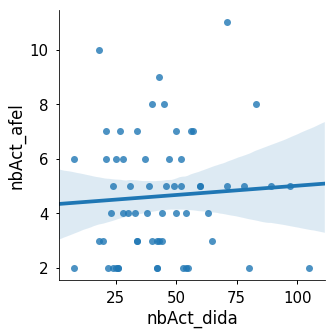

In [20]:
sns.lmplot(x='nbAct_dida', y='nbAct_afel', data=DF_ALL)